<a href="https://colab.research.google.com/github/Shk-tech/my-colab-learning-material/blob/main/TorchExample_kakao_color_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
!git clone https://github.com/ladofa/edu

Cloning into 'edu'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 113 (delta 38), reused 38 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 33.46 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [ ]:
root = 'edu/samples/kakao-color/'

#학습 데이터 준비

In [ ]:
x_image = cv2.imread('/content/edu/samples/kakao-color/colormap_0.png')
x_image.reshape(-1, 3).shape

(262144, 3)

In [ ]:
x_images = []
y_images = []

for i in range(10):
    x_filename = root + 'colormap_%d.png'%i
    y_filename = root + 'w%d.jpg'%i
    x_image = cv2.imread(x_filename).reshape(-1, 3)
    x_images.append(x_image)
    y_image = cv2.imread(y_filename).reshape(-1, 3)
    y_images.append(y_image)

In [ ]:
# a = np.array(x_images).reshape(-1, 3)
# a.shape

In [ ]:
x_pixels = np.concatenate(x_images, axis=0)
y_pixels = np.concatenate(y_images, axis=0)
rand_idx = np.random.permutation(len(x_pixels))
x_train = torch.tensor(x_pixels[rand_idx], dtype=torch.float32) / 127.5 - 1 #-1 ~ +1
y_train = torch.tensor(y_pixels[rand_idx], dtype=torch.float32) / 127.5 - 1

In [ ]:
x_train.shape

torch.Size([2621440, 3])

In [ ]:
#참고...
# mean = x_train.mean(axis=0)
# std = x_train.std(axis=0)
# x_train_scaled = (x_train - mean) / std
# x_train_scaled[:10]

In [ ]:
x_valid = torch.tensor(cv2.imread(root+'test.jpg').reshape(-1, 3), dtype=torch.float32) / 127.5 - 1
y_valid = torch.tensor(cv2.imread(root+'test_w.jpg').reshape(-1, 3), dtype=torch.float32) / 127.5 - 1

In [ ]:
# 학습속도 d LOSS / d T  (단위시간당 loss 감소량)
# d LOSS / d EPOCH   (1 이포크(샘플전체) 당 loss 감소량) - 데이터의 효율성...
# d EPOCH / d T     ( 시간 당 이포크 진행 수 ) - 하드웨어의 성능...

# d LOSS / d STEPS
# d STEPS / d T

# 하드웨어 최적화를 위해서는 하드웨어의 용량에 걸맞는 batch_size (최대한 크게) 하는 것이 좋다.
# 너무 큰 크기의 batch_size -> batch_size로 얻는 이득 감소 (샘플의 다양성 감소, batch_normalization 의 효율 감소)

In [ ]:
# from numpy.random.mtrand import shuffle
# https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
batch_size = 8192

# dataset_train = torch.utils.data.TensorDataset(x_train, y_train) #zip 기능 포함
dataset_train = list(zip(x_train, y_train)) # dataset_train[??] 각괄호 연산만 잘 작동하면 됨.

loader_train = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size, drop_last=True, shuffle=True)
len(loader_train)

320

In [ ]:
for x, y in loader_train:
    break
x.shape, y.shape

(torch.Size([8192, 3]), torch.Size([8192, 3]))

In [ ]:
# nn.Linear(2, 3) #weight, bias
nn.ReLU()
nn.SiLU()


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# ...
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(3, 8),
            nn.Tanh(),
            nn.Linear(8, 8),
            nn.Tanh(),
            nn.Linear(8, 3),
        )

    def forward(self, input):
        z = self.body(input)
        z = torch.clip(z, -1, 1)
        return z
model = MyModel()

In [ ]:
class Clip(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return torch.clip(input, -1, 1)

model = nn.Sequential(
    nn.Linear(3, 8),
    nn.Tanh(),
    nn.Linear(8, 8),
    nn.Tanh(),
    nn.Linear(8, 3),
    Clip()
)

model = model.to(device)
opt = torch.optim.AdamW(model.parameters())
loss_fn = nn.MSELoss()

In [ ]:
for epoch in range(50):
    #train
    loss_list = []
    model.train()
    for step, (x, y) in enumerate(loader_train): #loader_train에서 나오는 샘플은 전부 cpu
        pred = model(x.to(device))
        y_gpu = y.to(device)
        loss = loss_fn(pred, y_gpu)

        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_list.append(loss.item()) # item연산은 순수 python 타입을 리턴 (스칼라에서만 동작)
        print(f'\r[{epoch}]{step} loss={np.mean(loss_list) * 1000:.4f}', end='')

    #valid
    model.eval()
    with torch.no_grad():
        pred = model(x_valid.to(device)).to('cpu')
    loss = loss_fn(pred, y_valid).item()
    print(f'     val_loss={loss * 1000:.4f}')

[0]319 loss=134.2543     val_loss=19.6398
[1]319 loss=25.7977     val_loss=12.5673
[2]319 loss=17.7813     val_loss=8.8298
[3]319 loss=10.7951     val_loss=9.8872
[4]319 loss=8.5996     val_loss=9.4264
[5]319 loss=7.5510     val_loss=9.2704
[6]319 loss=6.7646     val_loss=9.2514
[7]319 loss=6.2013     val_loss=8.5859
[8]319 loss=5.7450     val_loss=7.3738
[9]319 loss=5.2776     val_loss=5.9229
[10]319 loss=4.7501     val_loss=4.8387
[11]319 loss=4.2817     val_loss=4.5699
[12]319 loss=3.9574     val_loss=4.5827
[13]319 loss=3.7037     val_loss=4.6607
[14]319 loss=3.4860     val_loss=4.6431
[15]319 loss=3.2865     val_loss=4.3424
[16]319 loss=3.0884     val_loss=3.8925
[17]319 loss=2.8852     val_loss=3.4083
[18]319 loss=2.6777     val_loss=3.0420
[19]319 loss=2.4736     val_loss=2.6969
[20]319 loss=2.2948     val_loss=2.5785
[21]319 loss=2.1566     val_loss=2.4541
[22]319 loss=2.0595     val_loss=2.4195
[23]319 loss=1.9914     val_loss=2.3507
[24]319 loss=1.9400     val_loss=2.3546
[25

In [ ]:
# 학습 결과 error가 계산되는데
# 클라이언트의 요구사항을 충족하려면 error가 얼마여야 할까?
# 1. 요구사항을 만족하는 에러가 얼마인가?
# 2. 현재 수준이면 어느 정도로 요구사항을 만족하는가?

In [ ]:
# ex) 밝기값 최대 10차이가 나야 한다
#     -> 평균으로 환산 5
#     -> 스케일 적용 5 / 127.5
#     -> 제곱 적용
(5 / 127.5) ** 2 # 목표 mse

0.0015378700499807767

In [ ]:
mse = 0.0026974
#rmse를 구한다
rmse = mse ** 0.5
#scale 을 보정한다
# 스케일 : 0~255 -> -1~+1  => /127.5
# unscale... * 127.5
rmse * 127.5

6.6219037104144

In [ ]:
import torchsummary
torchsummary.summary(model, (3,)) # 모델, 입력크기 (N을 제외)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              32
              Tanh-2                    [-1, 8]               0
            Linear-3                    [-1, 8]              72
              Tanh-4                    [-1, 8]               0
            Linear-5                    [-1, 3]              27
              Clip-6                    [-1, 3]               0
Total params: 131
Trainable params: 131
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
# 모델의 크기를 평가할 때 사용하는 기준
# 1. 파라미터의 개수
# 2. 사용하는 연산의 개수 (FLOPs - FLoating OPerations)

In [ ]:
# 학습 속도 - 성능
# dLoss/time -> 같은 시간에 얼마나 성능이 좋아지는가
# dLoss/epoch -> 학습 샘플 하나를 돌려서 얼마나 성능이 좋아지는가
# epoch/time -> 같은 시간에 얼마나 많은 샘플을 소화하는가
# dLoss/epoch * epoch/time -> dLoss/time

# 배치 사이즈를 어떻게 설정할 것인가?
# 배치 사이즈↑ ... epoch/time↑ ... 샘플 전체를 더 빠른 시간에 적용해볼 수 있다.
#            ... 처리데이터 증가 ... 1스텝당 시간 소요 증가해야 하는데....
#                어느정도 규모까지는 배치사이즈가 올라가도 GPU 속도가 똑같음.
# 배치 사이즈↓ ... dLoss/epoch↑ .. 1epoch->steps증가.     100, 50 2
# 하드웨어 효율성... 배치 사이즈가 너무 작으면 효율성 감소.
#.... -> 8192

In [ ]:
!wget https://file.mk.co.kr/meet/neds/2022/08/image_readtop_2022_761383_16617354415150451.jpg -O newjeans.jpg

--2025-05-23 10:21:47--  https://file.mk.co.kr/meet/neds/2022/08/image_readtop_2022_761383_16617354415150451.jpg
Resolving file.mk.co.kr (file.mk.co.kr)... 211.110.12.146, 222.239.240.27, 211.110.12.147
Connecting to file.mk.co.kr (file.mk.co.kr)|211.110.12.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129336 (126K) [image/jpeg]
Saving to: ‘newjeans.jpg’

newjeans.jpg        100%[===================>] 126.30K   172KB/s    in 0.7s    

2025-05-23 10:21:50 (172 KB/s) - ‘newjeans.jpg’ saved [129336/129336]



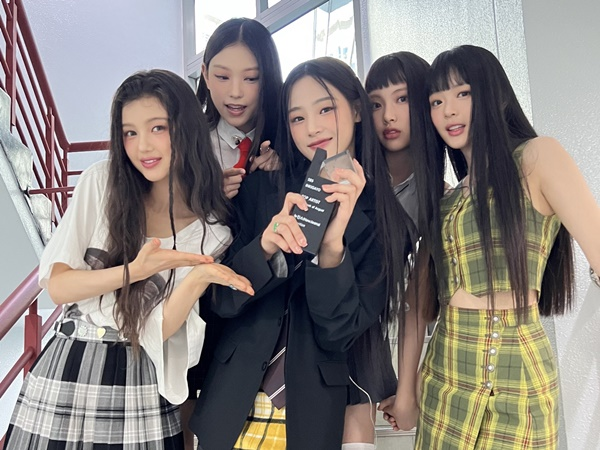

In [ ]:
image = cv2.imread('newjeans.jpg')
cv2_imshow(image)

In [ ]:
image.shape

(450, 600, 3)

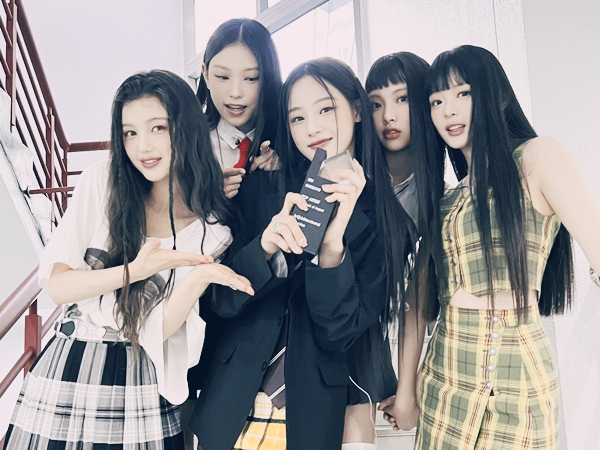

torch.Size([270000, 3])

In [ ]:
input = image.reshape(-1, 3)
input = torch.tensor(input)
input = input.type(torch.float32) / 127.5 - 1
input = input.to(device)

model.eval() # 실행모드
with torch.no_grad(): # 학습하지 않음.
    output = model(input)

output = output * 127.5 + 127.5
output = output.to('cpu').numpy()
output = np.clip(output, 0, 255).astype(np.uint8)
output = output.reshape(image.shape)

cv2_imshow(output)

input.shape

In [ ]:
class FinalModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, image):
        #HWC - uint8
        #scaling
        input = image.float() / 127.5 - 1
        input = input.reshape(-1, 3)
        output = self.model(input)
        output = output.reshape(image.shape)
        output = output * 127.5 + 127.5
        output = torch.clip(output, 0, 255).type(torch.uint8)
        return output


final_model = FinalModel(model)

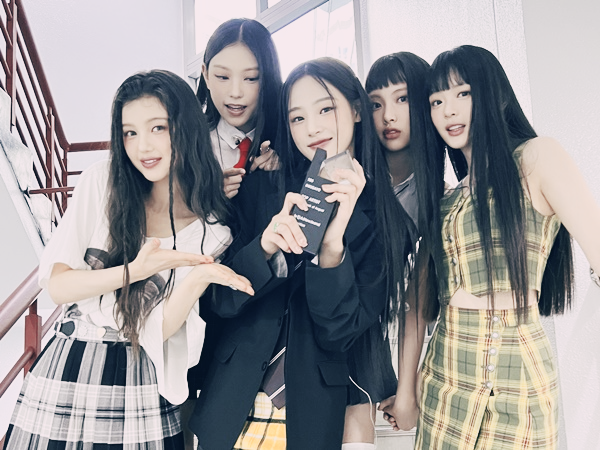

In [ ]:
image = cv2.imread('newjeans.jpg')
final_model.to(device)
final_model.eval()
with torch.no_grad():
    output = final_model(torch.tensor(image).to(device)).to('cpu').numpy()
cv2_imshow(output)

## 실행 전용 모델, 추론엔진 (Inference Engine, Deep Learning Runtime)
- 학습된 모델을 실행하는 데 특화된 프레임워크
- OnnxRuntime, TfLite, ncnn, Race, TNN, OpenCV DNN 등
- 실행 전용 모델을 쓰는 이유
 1. 불필요한 기능을 없애기 위해
 2. 개별 하드웨어에 대한 최적화가 필요하므로
  - 학습 프레임워크는 Intel, NVidia GPU에 최적화되어 있음
  - 실행 기능만 ARM, Adreno 등 여러 기기에 에 최적화
 3. 실행만 한다고 가정하면 연산을 단축시킬 수 있다.
  - ex) BatchNormalization $ \frac{(x - \mu)}{\sigma} \cdot \gamma + \beta $
 4. float16(FP16)으로 단축

# onnx
- Open Neural Network eXchange
- 딥러닝 초창기에 학습된 모델 간의 프레임워크 변환을 위해 개발
 - 1:1로 변환하는 대신 onnx를 거쳐서 변환
 - ex) PyTorch -> onnx -> TensorFlow -> TfLite
- TensorFlow 혹은 PyTorch가 점유율을 높게 차지하면서 활용도가 떨어짐
- 이었다가 PyTorch에서 추론엔진을 개발하지 않고, 저마다 추론엔진이 만들어지면서 표준 포맷으로 쓰임
 - 세상의 거의 모든 추론엔진은 onnx를 실행할 수 있음




In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 101.9 MB/s eta 0:00:00


In [ ]:
sample_input = torch.rand((1, 1, 3)).type(torch.uint8).to(device) # 입력 타입과 shape을 지정

torch.onnx.export(
    final_model,                  # PyTorch Model
    sample_input,            # Input tensor, dtype=uint8, shape=(1, 1, 3)
    "model.onnx",        # Output file (eg. 'output_model.onnx')
    opset_version=12,       # Operator support version
    input_names=['input'],   # Input tensor name (arbitary)
    output_names=['output'], # Output tensor name (arbitary)
    dynamic_axes={'input':[0, 1]}
)

/usr/local/lib/python3.11/dist-packages/torch/onnx/utils.py:1828: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  warnings.warn(


In [ ]:
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import onnxruntime

session = onnxruntime.InferenceSession('model.onnx')
inputs = session.get_inputs()

In [ ]:
inputs

In [ ]:
inputs[0].name

'input'

In [ ]:
inputs[0].type

'tensor(uint8)'

In [ ]:
inputs[0].shape

['input_dynamic_axes_1', 'input_dynamic_axes_2', 3]

In [ ]:
outputs = session.get_outputs()
outputs[0].name

'output'

In [ ]:
outputs[0].type

'tensor(uint8)'

In [ ]:
!wget https://file.mk.co.kr/meet/neds/2022/08/image_readtop_2022_761383_16617354415150451.jpg -O newjeans.jpg

--2025-08-11 02:48:30--  https://file.mk.co.kr/meet/neds/2022/08/image_readtop_2022_761383_16617354415150451.jpg
Resolving file.mk.co.kr (file.mk.co.kr)... 58.228.245.66, 222.239.240.27, 211.110.12.147
Connecting to file.mk.co.kr (file.mk.co.kr)|58.228.245.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129336 (126K) [image/jpeg]
Saving to: ‘newjeans.jpg’

newjeans.jpg        100%[===================>] 126.30K   575KB/s    in 0.2s    

2025-08-11 02:48:31 (575 KB/s) - ‘newjeans.jpg’ saved [129336/129336]



In [ ]:
image = cv2.imread('newjeans.jpg')
image.shape

(450, 600, 3)

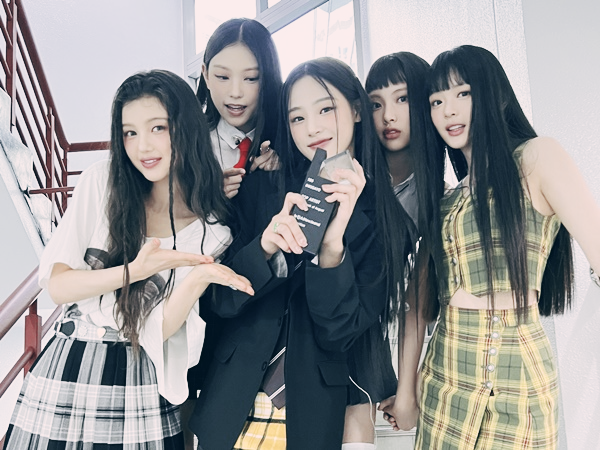

In [ ]:
# 다른 inference 모델도 사용법이 똑같음.
dst = session.run(None, input_feed={'input':image})[0]
cv2_imshow(dst)

In [ ]:
import torch
lin = torch.nn.Linear(3, 8)
dummy = torch.randn((1, 3))
y = lin(dummy)
y

In [ ]:
dummy @ lin.weight.T + lin.bias

In [ ]:
lin3(lin2(lin1(x)))

# GPU


In [ ]:
# 파이토치는 환상적인 GPU 라이브러리이다.
# GPU라는 것은 CPU 를 대신하는 연산장치
# CPU - 기술자 한명  GPU - 노무자 - 100 명
# CPU - 전체 시스템을 담당, 복잡한 연산이 가능,     GPU - 단순 연산을 수많은 코어로 빠르게 해냄
# Graphic Process Unit - GPGPU(General Purpose GPU) - NVidia CUDA
# 딥러닝 라이브러리는 100% CUDA(NVidia)  1%(TPU google)
# GPU - 독립된 컴퓨터 외부에 외장 컴퓨터... 내 데이터를 네트워크로 다른 컴퓨터에 전송, 계산하고, 결과 다시 네트워크로 받아오기
# torch.tensor, np.array - RAM => VRAM(GPU 내부의 메모리로 옮김)
# => GPU 연산 하고 VRAM => RAM

In [ ]:
a = torch.tensor([1, 2, 3, 4], device='cuda')
b = torch.tensor([5, 6, 7, 8], device='cuda')
c = a * b
c
# 출력 결과를 (. .) 에코로 출력하고 있는데 이말인 즉슨 VRAM-> RAM으로 임시로 옮겼다. 화면에 출력하려면 RAM으로 옮겨야 한다.

tensor([ 5, 12, 21, 32], device='cuda:0')

In [ ]:
#inplace가 아님....
c.to('cpu')
c.cpu()
c

tensor([ 5, 12, 21, 32], device='cuda:0')

In [ ]:
c.cpu().cuda()

In [ ]:
c.to('cuda').to('cpu')

In [ ]:
# 어떤 연산을 GPU로 할 것인가, CPU로 할 것인가를 연산자로 결정하지 않는다. (파이토치의 특징)
a * b
# 여기서 곱셈 연산자 *는 동일.

# func함수 내의 * 연산이 GPU인지 CPU인지 미리 결정하지 못함
def func(a, b):
    return a * b

In [ ]:
# device가 섞이면 안 된다.
torch.relu(a.cuda() * b.cuda())

tensor([ 5, 12, 21, 32], device='cuda:0')

In [ ]:
# Module은 어떨가?
# ex) torch.nn.Linear - 내부에 weights, bias의 파라미터와 연산을 합친 객체
lin = torch.nn.Linear(3, 2)
lin.to('cuda') # inplace

# lin내부의 파라미터 텐서를 gpu로 바꿈.
# 모듈은 자기 내부의 파라미터를 바꿈, 자기 자신을 리턴
dummy = torch.randn(5, 3)
y = lin(dummy.cuda())
y.shape # ????

# import torch.nn.functional as F

torch.Size([5, 2])

In [ ]:
lin.bias
# input @ weights + bias => y

In [ ]:
y = lin(dummy.cuda())
y.cpu().detach()